# Introductory note
<a id='section0'></a>
This is a [Jupyter Notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) with the purpose of making you familiar with the advanced Python-based [Brightway2 LCA framework](https://docs.brightway.dev/en/latest/#) and its various functionalities, all developed by Chris Mutel and colleagues from the Paul Sherrer Institute (PSI).

This tutorial is made for the old version of bw2, and is not meant to handle the new version bw25 (even if the framework remains quite similar). More informations can be found in the [documentation](https://docs.brightway.dev/en/latest/#)

<div class="alert alert-block alert-info">

This notebook is designed to explore **new features of recent developement** in the brightway community. Especially, ```lca_algebraic``` and ```premise``` are introduced to help performing the parametrization of LCI, prospective LCA, uncertainty and sensitivity analysis?(local and global).
</div>


<br>

---

The notebook is structured as follows:  

1. [Setup](#section1): *Import required libraries and load project & databases* <br><br>
2. [Parametrization](#section2): *How to parameterize the inventory using lca_algebraic*<br><br>
3. [Uncertainties](#section3): *How to do a MonteCarlo simulation in BW*<br><br>
4. [Sensitivity analysis](#section4): *How to perform a local and global sensitivity analysis with lca_algebraic*<br><br>
5. [Prospective LCA with ```premise```](#section5): *How to update the background database depending on SSP scenarios with premise library?* 

---

**Outcomes - what are we going to learn?**

By completing this notebook (run it locally on your machine and don't just read the code), you will be able to:
- fully characterize the uncertainy and sensitivity analysis using Brightway and ```lca_algebraic```
- fully take advantage of ```lca_algebraic``` to make easier the use of Brightway, especially to parametrize the inventory
- know a few methods to plot nice advanced visualization in python taking advantage of ```lca_algebraic``` and other python visualization libraries
- generate prospective background databases using ```premise``` library to help assessing the evolution of impacts depending on the decarbonization pathways 
<br>
---
Just for clarification, abbreviations used in the markdown cells of this notebook are:

| Abbreviation(s) | Written out |
| --- | --- |
| bw, BW2 | Brightway2 |
| FU | Functional unit |
| LCA | Life cycle assessment |
| LCI | Life cycle inventory |
| LCIA | Life cycle impact assessment |

---

<a id='section1'></a>
# 1. Setup

## 1.1. Import librairies

Import some useful libraries for data vizualisation, scientific computation 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Import now brightway libraries that are split into sublibraries :
- ``Brightway2-data`` handles storing and searching all data sources (databases, LCIA methods, etc.).
- ``Brightway2-calc`` does LCA calculations.
- ``Brightway2-io`` tools for the import, export, and management of inventory databases and impact assessment methods. LCA calculations.
- ``Brightway2-analyzer`` analyzes input data like databases and methods, as well as the result of LCA calculations.
- ``Brightway2-parameters`` Library for storing, validating, and calculating with parameters.

> it is better to import these libraries separately rather than a brutal ``from brightway2 import *`` since with the upcoming update bw25, this will not work anymore.- 

In [2]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc

Useful tips : one can be interested to check the version of the library imported since there can be some incompatibilities between libraries and databases version.  
Sumup of the compatibility of versions of Ecoinvent and Brightway2:   

In [70]:
# | Ecoinvent version 	| Brightway Version 	| bw2io Version   	|
# |-------------------	|-------------------	|-----------------	|
# | ecoinvent 3.8     	| bw2               	| bw2io 0.8.7     	|
# | ecoinvent 3.9     	| bw2               	| bw2io 0.8.8     	|
# | ecoinvent 3.8     	| bw2.5             	| bw2io 0.9.dev11 	|
# | ecoinvent 3.9     	| bw2.5             	| bw2io 0.9.dev10 	|

The command to show the version of one library is :

In [3]:
print(bi.__version__)

(0, 8, 12)


In [72]:
bd.projects

Brightway2 projects manager with 6 objects:
	PB
	TUTO
	default
	demo
	model
	tuto
Use `projects.report()` to get a report on all projects.

To create a new project or to access an existing one, we type in:

In [73]:
bd.projects.set_current("TUTO") #Creating/accessing the project

Look inside the project to know what datases are already imported:

In [74]:
bd.databases

Databases dictionary with 4 object(s):
	Foreground DB
	biosphere3
	ecoinvent 3.9.1_cutoff
	water_bottle

## 1.2 Load databases

In [75]:
bi.bw2setup() #Importing elementary flows, LCIA methods and some other data

Biosphere database already present!!! No setup is needed


To import ecoinvent, you need a license and download the ecoinvent file locally.

Let's check if it has already been imported with the following command

In [76]:
if 'ecoinvent 3.9.1_cutoff' in bd.databases:
    print("Database has already been imported.")
else:
    # mind that the ecoinvent file must be unzipped; then: path to the datasets subfolder
    fp = r"C:\Users\User\Documents\Ecoinvent 3.9\ecoinvent 3.9.1_cutoff_ecoSpold02\datasets" # the "r" makes sure that the path is read as a string - especially useful when you have spaces in your string
    ei = bi.SingleOutputEcospold2Importer(fp, 'ecoinvent 3.9.1_cutoff') 
    ei.apply_strategies() #apply functions to normalize the flows, turn into a adequate format and match all the properties of the flows (name, unit, reference product, location...)
    ei.statistics() #to check if some flows have no match
    ei.write_database() #regestire the database

Database has already been imported.


In [77]:
bd.databases

Databases dictionary with 4 object(s):
	Foreground DB
	biosphere3
	ecoinvent 3.9.1_cutoff
	water_bottle

In [78]:
len(bd.Database("ecoinvent 3.9.1_cutoff"))

21255

In [79]:
db_background = bd.Database("ecoinvent 3.9.1_cutoff")

To delete a database, here is the syntax:

In [80]:
# del bd.databases['ecoinvent 3.9.1_cutoff']
# bd.databases

Now, we are ready to explore advanced functions of BW and other libraries

**Continue, or back to [table of contents](#section0)?**
***

<a id='section2'></a>
# 2. Parametrization

This section comes directly from a simplified version of the notebook ```example-notebook.ipynb``` introduced in this [Github repository](https://github.com/oie-mines-paristech/lca_algebraic/)

**lca-algebraic** is a small libray above **brightay2**, designed for the definition of **parametric inventories** with fast computation of LCA impacts, suitable for **monte-carlo** analyis.

**lca-algebraic** provides a set of  **helper functions** for : 
* **compact** & **human readable** definition of activites :  
    * search background (tech and biosphere) activities 
    * create new foreground activites with parametrized amounts
    * parametrize / update existing background activities (extending the class **Activity**)
* Definition of parameters
* Computation of LCAs 
* Computation of statistics (including Sobols indices)
* Compute simplified parametric model by fixing minor input parameters

<div class="alert alert-block alert-info">

The main idea of this libray is to move from **procedural definition** of models (slow and prone to errors) to a **declarative / purely functionnal definition of parametric models** (models as pure functions). 

This enables **fast computation of LCA impacts**, useful for Monte Carlo methods and statistical analysis. We leverage the **power of symbolic calculus** provided by the library [SymPy](https://www.sympy.org/en/index.html).

</div>

Each activity of our **root model** is defined as a **parametrized combination** of the **foreground activities**, which can themselves be expressed by the **background activities**.

When computing LCA for foreground models, the library develops the model as a combination of **only background activities**. It computes **once for all** the impact of **all required background activities** and compiles a **fast numpy** (vectorial) function for each impact, replacing each background activity by the **static value of the corresponding impact**.

By providing **large vectors** of **parameter values** to those numpy functions, we can compute LCA for **thousands of values** at a time.
Parameters are also stored in the **brightay2** projets, making it fully compatible with **brightway**.

Thus, a model defined with **lca-algebraic** is stored as a regular **bw2** projet. We can use **bw2** native support for [parametrized dataset](https://2.docs.brightway.dev/intro.html#parameterized-datasets) for computing LCAs, even if much more slower than the method explain here.

Full documentation of the functions is [available here](https://oie-mines-paristech.github.io/lca_algebraic/doc/)

## 2.1 Setup the library

In [81]:
from lca_algebraic import * #import the libraries

Init the brightway2 project : choose any project name

In [82]:
initProject('TUTO')

# Import Ecoinvent DB (if not already done)
# Update the name and path to the location of the ecoinvent database
# importDb("ecoinvent 3.4", './ecoinvent 3.4_cutoff_ecoSpold02/datasets')


Biosphere database already present!!! No setup is needed


We use a separate DB for defining our foreground model / activities

In [83]:
db_user = 'Foreground DB'

This is better to clean up the whole foreground model each time, and redefine it in the notebook instead of relying on a state or previous run.
Any persistent state is prone to errors.


In [84]:
resetDb(db_user)

Db Foreground DB was here. Reseting it


Parameters are stored at project level : Reset them also
You may remove this line if you import a project and parameters from an external source (see loadParam(..))

In [85]:
resetParams()

Overview of the databases


In [86]:
list_databases()

,backend,type
name,,
biosphere3,sqlite,background
water_bottle,sqlite,background
ecoinvent 3.9.1_cutoff,sqlite,background
Foreground DB,sqlite,foreground


Some **helping functions** have been developped to help searching activities in a brightway database:

* **findBioAct** : Search activity in **biosphere3** db
* **findTechAct** : Search activity in **ecoinvent** db
* **findActivity** : search activity in one specific db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search : 
They will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.

In [87]:
# Biosphere activities
ground_occupation = findBioAct('Occupation, industrial area') # Search by name
heat = findBioAct('Heat, waste', categories=['air']) # Add category selector

# Technosphere activities

# You can add an optionnal location selector
alu = findActivity("aluminium alloy production, AlMg3", loc="RER", db_name="ecoinvent 3.9.1_cutoff")
alu_scrap = findActivity('aluminium scrap, new, Recycled Content cut-off',db_name="ecoinvent 3.9.1_cutoff")

# Elec 
eu_elec = findActivity("market group for electricity, medium voltage", 'ENTSO-E',db_name="ecoinvent 3.9.1_cutoff")
us_elec = findActivity("market group for electricity, medium voltage", 'US',db_name="ecoinvent 3.9.1_cutoff")

A **really useful** helper method is **printAct** to print every exchanges of an Activity:

In [88]:
printAct(alu)

aluminium alloy production, AlMg3[RER] (1.000000 kilogram)  \
                                                                                  input   
aluminium, cast alloy                          market for aluminium, cast alloy           
cast iron                                                  market for cast iron           
chromium                                                    market for chromium           
copper, cathode                                      market for copper, cathode           
electricity, medium voltage   market group for electricity, medium voltage[RER]           
magnesium                                                  market for magnesium           
manganese                                                  market for manganese           
silicon, metallurgical grade            market for silicon, metallurgical grade           
zinc                                                            market for zinc           

                                                      
                               amount           unit  
aluminium, cast alloy           0.965       kilogram  
cast iron                     0.00406       kilogram  
chromium                      0.00305       kilogram  
copper, cathode               0.00102       kilogram  
electricity, medium voltage      1.59  kilowatt hour  
magnesium                      0.0305       kilogram  
manganese                     0.00508       kilogram  
silicon, metallurgical grade  0.00406       kilogram  
zinc                          0.00203       kilogram

In [89]:
# You print several activities at once to compare them
printAct(alu, alu_scrap)

c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\lca_algebraic\helpers.py:706: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[iamount1] != row[iamount2]:
c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\lca_algebraic\helpers.py:709: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[iact1] != row[iact2]:


## 2.2 Introduction to symbolic calculus

Numpy is a python libray for symbolic calculus. 

You write Sympy expression as you write **standard python expressions**, using **sympy symbols** in them. 


The result is then a **symbolic expression that can be manipulated**, instead of a **numeric value**.

In [90]:
from sympy import symbols 

# create sympy symbol
a = symbols("a")

# Expressions are not directly evaluated 
f = a * 2 + 4 
f

2*a + 4

In [91]:
# symbols can be replaced by values afterwards 
f.subs(dict(a=3))

10

In practice, you don't need to care about Sympy. Just remember that : 
* The parameters defined below are **instances of sympy symbols**
* Any **valid python expression** containing a **sympy symbol** will create a **sympy symbolic expression**

## 2.3 Define input parameters

First, we define the input parameters of the model together with their distribution.

The numeric parameters are **instances of sympy 'Symbol'**. 

Thus, any python arithmetic expression composed of parameters will result in a **symbolic expression** to be used later in the definition of the model, rather than a static numeric result.

In [92]:
# Example of 'float' parameters
a = newFloatParam(
    'a', 
    default=0.5, min=0.2, max=2,  distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world",
    label="extended label for a")

b = newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    description="foo bar")

# Parameters can be attached to a specific DB instead of global project
# We recommand this for team working / working with several DBs
# lca_algebraic supports resolution of parameters with duplicate names attached to different scopes 
b2 = newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    description="foo bar",
    dbname=db_user)

share_recycled_aluminium = newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, min=0, max=1, std=0.2, distrib=DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

c = newFloatParam(
    'c',  
    default=0.6, std=0.2, distrib=DistributionType.LOGNORMAL)

beta = newFloatParam(
    'beta',  
    default=0.6, std=0.2, a=2, b=5, distrib=DistributionType.BETA)

# You can define boolean parameters, taking only discrete values 0 or 1
bool_param = newBoolParam(
    'bool_param', 
    default=1)

# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], # If provided as list, all possibilities have te same probability
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = newEnumParam(
    'techno_param', 
    values={
        "technoA":0.4, 
        "technoB":0.1,
        "technoC":0.5}, # You can provide a statistical weight for each value, by using a dict
    default="technoA", 
    description="Choice of techonoly")

No 'min/max' provided, param b marked as FIXED
No 'min/max' provided, param b marked as FIXED


In [93]:
# List of parameters
list_parameters()

group,name,label,default,min,max,std,distrib,unit,db
,a,extended label for a,0.5,0.2,2,,triangle,,[project]
,b,b,0.5,,,,fixed,,[project]
,b,b,0.5,,,,fixed,,Foreground DB
,beta,beta,0.6,,,0.2,beta,,[project]
,bool_param,bool param,1,,,,,,[project]
,c,c,0.6,,,0.2,lognormal,,[project]
,elec_switch_param,elec switch param,us,,,,,,[project]
,share_recycled_aluminium,share recycled aluminium,0.6,0,1,0.2,normal,,[project]
,techno_param,techno param,technoA,,,,,,[project]


A foreground database can be "frozen" to be used as a background database for a specific scenario : the parametrized amounts in the exhanges are computed for a given configuration of the parameters, and replaced by their value. The formulas are still stored in the database and not lost : the database can still be used as a foreground database until its status is changed with `setBackground(...)`.

This feature is useful for studies requiring several datasets to be used as background by other ones. It also enables to use standard Brightway2 tools, not aware of parametrization. 


In [94]:
freezeParams(
    db_user, # Name of database to freeze
    
    a=1, b=2) # custom parameter values

## 2.4 Create new activities with parametrized exchanges

In [95]:
# Create a new activity
activity1 = newActivity(db_user, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with a switch parameter
elec_mix = newSwitchAct(db_user, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec, # By default associated amount is 1
        "eu" : (eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
    })

You can **copy and update** an existing background activity.

Several new helper methods have been added to the class **Activity** for easy update of exchanges.

In [96]:
alu2 = copyActivity(
    db_user, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Aluminium 2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=activity1)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

Usually, we normalize the final model as the whole LCI divided by the functional value (production of the system)

In [97]:
functional_value = a + 5

model = newActivity(db_user, "model", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a})

normalized_model = newActivity(db_user, "normalized model", "kg", {
    model : 1 / functional_value})

In [98]:
printAct(model)

model (1.000000 kg)  \
                                                                    input   
Aluminium 2                                          Aluminium 2[RER]{FG}   
aluminium alloy production, AlMg3  aluminium alloy production, AlMg3[RER]   
first foreground activity                   first foreground activity{FG}   

                                                                         
                                                       amount      unit  
Aluminium 2                        3*share_recycled_aluminium  kilogram  
aluminium alloy production, AlMg3                       0.4*a  kilogram  
first foreground activity                         a + 5*b + 1        kg

In [99]:
# You can also compute amounts by replacing parameters with a float value 
printAct(model, a=0, b=1.5) 

model (1.000000 kg)  \
                                                                    input   
Aluminium 2                                          Aluminium 2[RER]{FG}   
aluminium alloy production, AlMg3  aluminium alloy production, AlMg3[RER]   
first foreground activity                   first foreground activity{FG}   

                                                                         
                                                       amount      unit  
Aluminium 2                        3*share_recycled_aluminium  kilogram  
aluminium alloy production, AlMg3                           0  kilogram  
first foreground activity                    8.50000000000000        kg

## 2.5 Compute LCA (more) easily

````lca_algebraic```` provide two methods  for computing LCA : 
* **multiLCA** : It uses **brightway2** native parametric support. It is **much slower** and kept for **comparing results**.
* **multiLCAAlgebric** : It computes an algebric expression of the model and computes LCA once for all the background activities. Then it express each impact as a function of the parameters. This expression is then compiled into 'numpy' native code, for fast computation on vectors of samples. This version is 1 million time faster.

In [100]:
methods_EF=findMethods('EF v3.0 no LT')
list_methods=methods_EF
len(list_methods)

28

You can provide short names for some methods

In [101]:
set_custom_impact_labels({
    methods_EF[0] : 'AC',
    methods_EF[1] : 'CC',
    methods_EF[2] : 'CC (biogenic)',
    methods_EF[3] : 'CC (fossil fuels)',
    methods_EF[4] : 'CC(land use)',
    methods_EF[5] : 'ECOTOX',
    methods_EF[6] : 'ECOTOX, inorg',
    methods_EF[7] : 'ECOTOX, metals',
    methods_EF[8] : 'ECOTOX, org',
    methods_EF[9] : 'ADP, fossil fuels',
    methods_EF[10] : 'EP freshwater (P)',
    methods_EF[11] : 'EP marine (N)',
    methods_EF[12] : 'EP terrestrial',
    methods_EF[13] : 'HTOX_c',
    methods_EF[14] : 'HTOX_c inorg',
    methods_EF[15] : 'HTOX_c, metals',
    methods_EF[16] : 'HTOX_c, org',
    methods_EF[17] : 'HTOX_nc',
    methods_EF[18] : 'HTOX_nc, inorg',
    methods_EF[19] : 'HTOX_nc, metals',
    methods_EF[20] : 'HTOX_nc, org',
    methods_EF[21] : 'IR',
    methods_EF[22] : 'LU',
    methods_EF[23] : 'ADP, ultimate reserves',
    methods_EF[24] : 'ODP',
    methods_EF[25] : 'PM',
    methods_EF[26] : 'POF',
    methods_EF[27] : 'WU',
})

In [102]:
# Uses brightway2 parameters
multiLCA(
    normalized_model, 
    list_methods, 
                   
    # Parameters of the model
    a=1, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

Freezing 'model' (kg, GLO, None) // first foreground activity : a + 5*b + 1 => 4
Freezing 'model' (kg, GLO, None) // Aluminium 2 : 3*share_recycled_aluminium => 1
Freezing 'model' (kg, GLO, None) // aluminium alloy production, AlMg3 : 0.4*a => 0
Freezing 'normalized model' (kg, GLO, None) // model : 1/(a + 5) => 0
Freezing 'Aluminium 2' (kilogram, RER, None) // aluminium, cast alloy : 0.965 - 0.965*share_recycled_aluminium => 0
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : elec_switch_param_us => 1
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : 0.8*elec_switch_param_eu => 0
Freezing 'first foreground activity' (kg, GLO, None) // Occupation, industrial area : 3*b => 1
Freezing 'first foreground activity' (kg, GLO, None) // Heat, waste : b + 0.2 => 0


,AC,CC,CC (biogenic),CC (fossil fuels),CC(land use),ECOTOX,"ECOTOX, inorg","ECOTOX, metals","ECOTOX, org","ADP, fossil fuels",...,"HTOX_nc, inorg","HTOX_nc, metals","HTOX_nc, org",IR,LU,"ADP, ultimate reserves",ODP,PM,POF,WU
normalized model,0.008493,1.517956,0.002789,1.512002,0.003165,44.109788,6.005406,37.728402,0.37598,16.754998,...,7.967403e-09,2.664065e-08,5.426777e-10,0.044039,326.891324,0.000016,1.895133e-08,2.557393e-07,0.005331,0.361561


In [103]:
# Compute with algebric implementation 
# The values should be the same as above
multiLCAAlgebric(
    normalized_model, # The model 
    list_methods, # Impacts
    
    # Parameters of the model
    a=1, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,AC[mol H+-Eq],CC[kg CO2-Eq],CC (biogenic)[kg CO2-Eq],CC (fossil fuels)[kg CO2-Eq],CC(land use)[kg CO2-Eq],ECOTOX[CTUe],"ECOTOX, inorg[CTUe]","ECOTOX, metals[CTUe]","ECOTOX, org[CTUe]","ADP, fossil fuels[MJ, net calorific value]",...,"HTOX_nc, inorg[CTUh]","HTOX_nc, metals[CTUh]","HTOX_nc, org[CTUh]",IR[kBq U235-Eq],LU[dimensionless],"ADP, ultimate reserves[kg Sb-Eq]",ODP[kg CFC-11-Eq],PM[disease incidence],POF[kg NMVOC-Eq],WU[m3 world eq. deprived]
normalized model,0.008493,1.517956,0.002789,1.512002,0.003165,44.109785,6.005405,37.7284,0.37598,16.754996,...,7.967403e-09,2.664065e-08,5.426777e-10,0.044039,326.891308,0.000016,1.895133e-08,2.557393e-07,0.005331,0.361561


You can compute several LCAs of different product at once

In [38]:
# You can compute several LCAs at a time and compare them:
multiLCAAlgebric(
    [alu, alu2], # The models
    
    list_methods, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us")

,AC[mol H+-Eq],CC[kg CO2-Eq],CC (biogenic)[kg CO2-Eq],CC (fossil fuels)[kg CO2-Eq],CC(land use)[kg CO2-Eq],ECOTOX[CTUe],"ECOTOX, inorg[CTUe]","ECOTOX, metals[CTUe]","ECOTOX, org[CTUe]","ADP, fossil fuels[MJ, net calorific value]",...,"HTOX_nc, inorg[CTUh]","HTOX_nc, metals[CTUh]","HTOX_nc, org[CTUh]",IR[kBq U235-Eq],LU[dimensionless],"ADP, ultimate reserves[kg Sb-Eq]",ODP[kg CFC-11-Eq],PM[disease incidence],POF[kg NMVOC-Eq],WU[m3 world eq. deprived]
"aluminium alloy production, AlMg3[RER]",0.043437,7.309373,0.015893,7.276195,0.017285,215.955010,30.562467,183.555768,1.836775,78.924241,...,3.982443e-08,1.354462e-07,2.529605e-09,0.179857,16.734135,0.000081,9.484865e-08,1.092534e-06,0.025998,1.915637
Aluminium 2[RER],0.031580,5.720096,0.009696,5.698820,0.011580,166.032095,22.468918,142.157516,1.405660,62.797833,...,2.979303e-08,9.943789e-08,2.033256e-09,0.165058,847.633477,0.000059,6.902785e-08,9.583869e-07,0.019950,1.315192


## 2.6 Advanced visualization of contribution analysis 

### Heatmap for multi-impact visualization

To plot all impact categories, one interesting solution is in heatmaps, by comparing the relative increase compared to one reference activity in each impact categories. Here is the syntax

In [104]:
df_results = multiLCAAlgebric([alu, alu2], list_methods)

#we normalize by the results of the reference activity
df_norm = (df_results / df_results.iloc[0]) #normalizaton with the results from the activity wind
df_norm

Required param 'elec_switch_param' was missing, replacing by default value : us
Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6


,AC[mol H+-Eq],CC[kg CO2-Eq],CC (biogenic)[kg CO2-Eq],CC (fossil fuels)[kg CO2-Eq],CC(land use)[kg CO2-Eq],ECOTOX[CTUe],"ECOTOX, inorg[CTUe]","ECOTOX, metals[CTUe]","ECOTOX, org[CTUe]","ADP, fossil fuels[MJ, net calorific value]",...,"HTOX_nc, inorg[CTUh]","HTOX_nc, metals[CTUh]","HTOX_nc, org[CTUh]",IR[kBq U235-Eq],LU[dimensionless],"ADP, ultimate reserves[kg Sb-Eq]",ODP[kg CFC-11-Eq],PM[disease incidence],POF[kg NMVOC-Eq],WU[m3 world eq. deprived]
"aluminium alloy production, AlMg3[RER]",1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Aluminium 2[RER],0.478951,0.549948,0.41209,0.550589,0.406514,0.526163,0.477081,0.534198,0.539861,0.593038,...,0.504729,0.48202,0.610391,0.837419,50.439173,0.487332,0.541553,0.756755,0.540961,0.458015


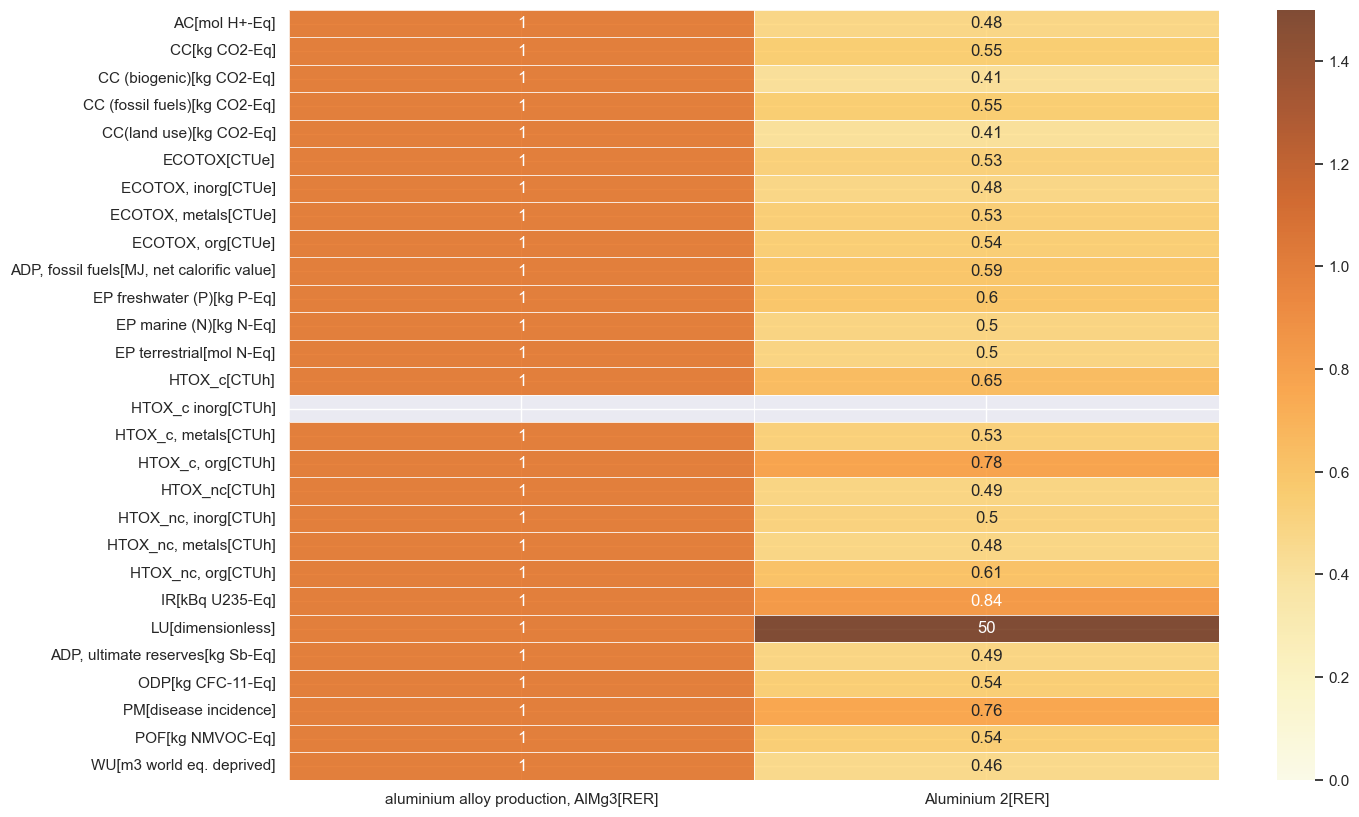

In [107]:
fig, axes = plt.subplots(figsize=(15,10))
sns.set_style("darkgrid")
sns.heatmap(df_norm.T,annot = True, cbar = True, ax=axes, cmap='YlOrBr', alpha=0.8, linewidth=0.5, xticklabels=True, vmin=0, vmax=1.5)
# plt.savefig("./outputs/" + "heatmap_example.png", dpi=600) #to save the plot
plt.show()

### Contribution analysis

A really **useful methods** is **exploreImpacts** that makes possible to perform a quick contribution analysis in one impact category and store the contributions within a dataframe that makes the data analysis and data visualization easier

if we want to plot the contribution analysis in GWP of the production of 1kg of aluminium, here is the syntax

In [108]:
CC = list_methods[1] #get the impact category from EF method related to climate change
CC

('EF v3.0 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [109]:
df_contribution = exploreImpacts(CC, alu)
df_contribution

aluminium alloy production, AlMg3[RER] (1.000000 kilogram)  \
                                                                                  input   
aluminium, cast alloy                          market for aluminium, cast alloy           
cast iron                                                  market for cast iron           
chromium                                                    market for chromium           
copper, cathode                                      market for copper, cathode           
electricity, medium voltage   market group for electricity, medium voltage[RER]           
magnesium                                                  market for magnesium           
manganese                                                  market for manganese           
silicon, metallurgical grade            market for silicon, metallurgical grade           
zinc                                                            market for zinc           

                                                 
                               amount    impact  
aluminium, cast alloy           0.965  5.667747  
cast iron                     0.00406    0.0076  
chromium                      0.00305  0.085881  
copper, cathode               0.00102  0.007198  
electricity, medium voltage      1.59  0.567594  
magnesium                      0.0305   0.89351  
manganese                     0.00508  0.028739  
silicon, metallurgical grade  0.00406  0.045535  
zinc                          0.00203  0.005568

A way to visualize this table is to represent the impacts in a stacked bar diagram, this way

In [110]:
share=pd.DataFrame(index=df_contribution.index, data={alu['name']:df_contribution.iloc[:,2].values}) #cleaning the previous dataframe to keep only the name of the exchanges and the related impact
share

,"aluminium alloy production, AlMg3"
"aluminium, cast alloy",5.667747
cast iron,0.0076
chromium,0.085881
"copper, cathode",0.007198
"electricity, medium voltage",0.567594
magnesium,0.89351
manganese,0.028739
"silicon, metallurgical grade",0.045535
zinc,0.005568


one might be intersted in defining method to doing this faster. Here is an example of a method to compute quickly the contribution and store it in a dataframe:

In [112]:
def contribution_phases(activity, list_methods,short_names):
    """
    From an activity and a method this function computes with the method (need the library lca_algebraic) exploreImpacts(), and buil the contribution of the steps of a process. 
    It returns a DataFrame of the % share of each components
    """
    a=pd.DataFrame(index=exploreImpacts(list_methods[0],activity).index)
    for i in list_methods:
        a[i]=(exploreImpacts(i,activity).iloc[:,2].values)
    a.columns=short_names
    return (a/(a.sum()))

Now, plot this dataframe as a stacked bar chart

C:\Users\TL268686\AppData\Local\Temp\ipykernel_8708\128750687.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.round(share.sum()[0],3),


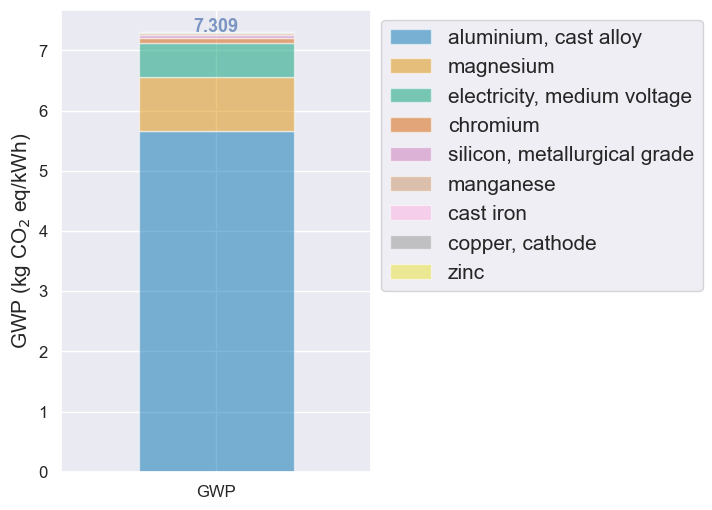

In [111]:
#Plot
colors = sns.color_palette('colorblind') #for pretty colors, (exist a large palette of colors with searborn) 
figure,ax1=plt.subplots(figsize=(4,6))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
sns.set() #seabron provide good looking display
sns.set_style('darkgrid')
# ax1.boxplot(result_mc.T['CC'], whis=[0,100],showmeans=False,positions=[0],showfliers=False) #for uncertainty analysis
share.sort_values(by=alu['name'], ascending=False).T.plot.bar(stacked=True,rot=0,color=colors,alpha=0.5,ax=ax1,fontsize=12, legend=None)
ax1.set_ylabel('GWP (kg CO$_2$ eq/kWh)', fontsize=15)
ax1.set_xticklabels(['GWP'])

bar_height1=[] ; bar_height2=[] 
for bar1 in ax1.patches: #for each bar, we catch the height and the number
    bar_height1.append(bar1.get_height())
ax1.text( #to add the numeric results on the bars
    ax1.patch.get_x(),
    ax1.patch.get_y() + sum(bar_height1),
    np.round(share.sum()[0],3),
    ha='center',
    color='b',
    weight='bold',
    alpha=0.7,
    size=13
)

ax1.legend(fontsize=15,bbox_to_anchor=(1,1))
# plt.savefig('Cradle-to-Gate_LCA_Contribution_GWP.png', dpi=600, bbox_inches='tight')
plt.show()

### Advanced visualization: Sankey & Sunburst

A more advanced visualization is possible using the ````plotly```` library to plot sankey diagram or sunburst chart

In [116]:
import plotly.express as px

The features of this library are quite difficult to use since it requires a really specific architecture of organizing data (in a treemap way with parents/children...)

Here is some functions to make automatically the transformations of the data obtained from contribution analysis in dataframe. These are designed to go only up to a level 3 of analysis (so the sub-sub-components) but with little modifications, this could be applied in a deeper analysis

In [117]:
def assign_parent_activities(df):
    """
    Assigns parent activities for each subcomponent in the DataFrame.

    Args:
    - df (DataFrame): DataFrame containing activities and their levels.

    Returns:
    - DataFrame: Updated DataFrame with a new column 'Parent' indicating parent activities.
    """
    parent_map = {}
    for i in df.index:
        level = df.at[i, 'Niveau']
        if level == 0:
            parent_map[i] = ''
        else:
            parent_index = i - 1
            while parent_index >= 0 and df.at[parent_index, 'Niveau'] >= level:
                parent_index -= 1
            parent_map[i] = df.at[parent_index, 'Activities']
    df['Parent'] = df.index.map(parent_map)
    return df

def generate_treemap_dataframe(names, values, niveau, activity, lcia_method, lca_obj=None, total_score=None, amount=1, level=0, max_level=3, cutoff=1e-2):
    """
    Recursively generates DataFrame for treemap plotting.

    Args:
    - names (list): List of activity names.
    - values (list): List of impact values.
    - niveau (list): List of activity levels.
    - activity (object): Activity object.
    - lcia_method (object): LCIA method object.
    - lca_obj (object): LCA object.
    - total_score (float): Total impact score.
    - amount (float): Amount of activity.
    - level (int): Current level of the activity.
    - max_level (int): Maximum level of the hierarchy.
    - cutoff (float): Cutoff threshold for impact score.

    Returns:
    - DataFrame: DataFrame for treemap plotting.
    """
    if lca_obj is None:
        lca_obj = bc.LCA({activity: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity: amount})
        if abs(lca_obj.score) >= abs(total_score * cutoff):
            names.append(activity["name"])
            values.append(lca_obj.score / total_score * 100)
            niveau.append(level)
    if level < max_level:
        for exc in activity.technosphere():
            generate_treemap_dataframe(
                names=names,
                values=values,
                niveau=niveau,
                activity=exc.input,
                lcia_method=lcia_method,
                lca_obj=lca_obj,
                total_score=total_score,
                amount=amount * exc['amount'],
                level=level + 1,
                max_level=max_level,
                cutoff=cutoff
            )
    return assign_parent_activities(pd.DataFrame({'Activities': names, 'Niveau': niveau, 'Values': values}))

def prepare_treemap_data(df):
    """
    Prepares DataFrame for treemap plotting.

    Args:
    - df (DataFrame): DataFrame containing hierarchical activity data.

    Returns:
    - DataFrame: DataFrame for treemap plotting.
    """
    components = []
    sub_components = []
    sub_sub_components = []
    values = []
    for i in df.index:
        if df.at[i, "Niveau"] == 3:
            values.append(df.at[i, 'Values'])
            sub_sub_components.append(df.at[i, 'Activities'])
            sub_components.append(df.at[i, 'Parent'])
            parent_index = i
            while df.at[parent_index, 'Activities'] != df.at[i, 'Parent']:
                parent_index -= 1
            components.append(df.at[parent_index, 'Parent'])
    df_plot = pd.DataFrame({'Components': components, 'Subcomponents': sub_components, 'Subsubcomponents': sub_sub_components, 'Values': values})
    
    return df_plot

Let's use these methods to plot the sankey and sunburst diagram of the aluminium activity

In [119]:
# Example usage
names, values, niveau = ['Total'], [100], [0]
df_treemap = generate_treemap_dataframe(names, values, niveau, alu, CC, amount=1, level=0, max_level=3, cutoff=0.01) #ajust the parameters of cutoff, amount
df_plot = prepare_treemap_data(df_treemap) #to go to a higher level than max_level=3, the function prepare_data_treemap should be updated subsequently

In [120]:
fig = px.treemap(df_plot, path=[px.Constant('Total'), 'Components', 'Subcomponents', 'Subsubcomponents'], values='Values', width=1200, height=400,
                  color='Values', color_continuous_scale='YlOrRd')
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.update_traces(hovertemplate=None, hoverinfo='value')
fig.show()


plotly produces htlm files that are interactive files. You can click on one contributors and it refreshes the chart.

This is the same syntax for plotting sunburst chart:

In [122]:
fig = px.sunburst(df_plot, path=[px.Constant('Total'), 'Components', 'Subcomponents', 'Subsubcomponents'], values='Values', width=1200, height=400,
                  color='Values', color_continuous_scale='YlOrRd')
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.update_traces(hovertemplate=None, hoverinfo='value')
fig.show()

**Back to [table of contents](#section0)?**
***

<a id='section3'></a>
# 3. Uncertainty analysis
 
According to British statistician George Cox "all models are wrong but some are useful" - in that light, quantifying uncertainty makes LCA results more reliable/robust. One of the easiest/ most common ways to do so is to perform a [Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method), a random sampling technique. Before elaborating on that, we need to understand how uncertainty information is stored in Brightway:

At first, let's get one activity that we will explore further. Assume we are interested in cement CEM II/A production in Switzerland.

In [114]:
act_cement = [act for act in db_background
              if 'cement production, CEM II/A' in act['name'] and 'CH' in act['location']][0]
act_cement

'cement production, CEM II/A' (kilogram, CH, None)

## 3.1 Uncertainty information in Brightway

Uncertainty is stored at the level of the exchanges - remember this! So, let's have a look at a random ecoinvent exchange:

In [25]:
[exc for exc in act_cement.exchanges()][0].as_dict()

{'flow': '7a439ec7-1840-4c4f-983f-1f07eda2053f',
 'type': 'production',
 'name': 'cement, CEM II/A',
 'classifications': {'CPC': ['374: Plaster, lime and cement']},
 'production volume': 1330360000.0,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'carbon content, fossil': {'amount': 0.0, 'unit': 'dimensionless'},
  'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'},
  'dry mass': {'amount': 1.0, 'unit': 'kg'},
  'price': {'amount': 0.0615,
   'unit': 'EUR2005',
   'comment': '2005 import and export prices (total trades (USD) divided by total weight (kg) in China, India, USA, Japan, Russia and Europe, major producers and consumers (http://www.cementchina.net/freport/showfre.asp?id=749) from UN Commodity Trade Statistics Database  (http://data.un.org/Explorer.aspxDatabase [Accessed 2 July 2010]). Commodity: Cement (portland, aluminious, slag or hydraulic)'},
  'water content': {'amou

The *necessary* uncertainty information of an exchange is described in the following fields:  
  - **'uncertainty type'** : type of probability distribution function that the exchange follows. For example, the uncertainty type = 2 indicates a `lognormal`  distribution.  
  - **'loc', 'scale', 'shape', 'minimum', 'maximum'**: parameters of the distribution function, which are respectively the location (mean $\mu$, mode, offset, or median), scale (e.g. standard deviation $\sigma$), and shape as well as minimum and maximum of the underlying distribution. Mind that different distribution functions require different parameters - not all parameters have to be defined for each distribution.

Some *additional* uncertainty related information ('scale without pedigree', 'pedigree') are also there, but are not directly used in the calculation of the uncertainty. They are also specific to ecoinvent.

Uncertainty in Brightway is dealt with using a Python package called `stats_arrays` (see [here](http://stats-arrays.readthedocs.io/en/latest/)), developed by Chris Mutel in the context of the development of Brightway but applicable to any stochastic model in Python. Have a look at it to see which probability distribution functions are available. And then, let's import this package!

In [26]:
import stats_arrays

Just to give a brief example of how the uncertainty information "works", let's have a look at the lognormal distribution. As a reminder:   
  - a random variable $X$ is a lognormal if its natural logarithm $ln(X)$ is normally distributed  
  - the natural logarithm of the *median* of the lognormal distribution is equal to the median (=mean) of the underlying distribution  

Taking the deterministic amount `amount` to be the median, we should have `loc` = `ln('amount')`. Let's do this for the first exchange of a random ecoinvent activity that has a lognormal distribution.  
>You can check it by lookiing at the uncertainty type in the activity

In [27]:
act_cement.as_dict()

{'comment': 'The dataset describes the production of cement (CEM II/A) in Switzerland and covers the representative production mix of CEM II/A-D, CEM II/A-LL and CEM II/A-S according to EN 197-1.',
 'classifications': [('ISIC rev.4 ecoinvent',
   '2394:Manufacture of cement, lime and plaster'),
  ('CPC', '374: Plaster, lime and cement')],
 'activity type': 'ordinary transforming activity',
 'activity': 'eee147aa-b76f-5a23-bb43-c7c7575273d3',
 'database': 'ecoinvent 3.9.1_cutoff',
 'filename': 'eee147aa-b76f-5a23-bb43-c7c7575273d3_7a439ec7-1840-4c4f-983f-1f07eda2053f.spold',
 'location': 'CH',
 'name': 'cement production, CEM II/A',
 'synonyms': [' CEM II/A', 'Portland composite cement'],
 'parameters': [],
 'authors': {'data entry': {'name': 'Frank Werner',
   'email': 'frank@frankwerner.ch'},
  'data generator': {'name': 'Frank Werner', 'email': 'frank@frankwerner.ch'}},
 'type': 'process',
 'reference product': 'cement, CEM II/A',
 'flow': '7a439ec7-1840-4c4f-983f-1f07eda2053f',
 'un

## 3.2 Basic Monte Carlo simulation

**One functional unit, one impact category**

In [115]:
ipcc2013 = [m for m in bd.methods if 'IPCC 2013 no LT' in str(m)
                        and 'GWP100' in str(m)][0]
ipcc2013

('IPCC 2013 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [116]:
#MC simulation with 10 iterations for our banana production and the IPCC GWP100a method
mc = bc.MonteCarloLCA({act_cement:1},  ipcc2013)
scores = [next(mc) for _ in range(10)]
scores

#or this way:
#for _ in range(10):
#    print(next(mc))

[0.6603241661153479,
 0.6019020881111935,
 0.5853348406604496,
 0.5929253352532222,
 0.6011307248969788,
 0.5538249238399421,
 0.675971505312477,
 0.6158740225206515,
 0.7250229156294593,
 0.5923886638645184]

Let's print the results of our MC:

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([0.55382492, 0.55810487, 0.56238482, 0.56666477, 0.57094472,
        0.57522467, 0.57950462, 0.58378457, 0.58806452, 0.59234447,
        0.59662442, 0.60090437, 0.60518432, 0.60946427, 0.61374422,
        0.61802417, 0.62230412, 0.62658407, 0.63086402, 0.63514397,
        0.63942392, 0.64370387, 0.64798382, 0.65226377, 0.65654372,
        0.66082367, 0.66510362, 0.66938357, 0.67366352, 0.67794347,
        0.68222342, 0.68650337, 0.69078332, 0.69506327, 0.69934322,
        0.70362317, 0.70790312, 0.71218307, 0.71646302, 0.72074297,
        0.72502292]),
 <BarContainer object of 40 artists>)

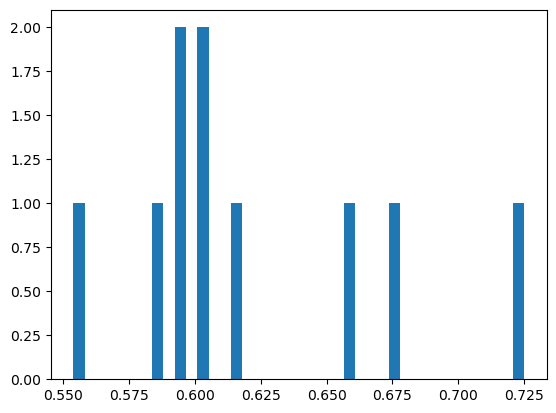

In [117]:
plt.hist(scores,bins=40)

Well, this doesn't really look like anything yet. We should increase the number of iterations - which yields more robust results. Around 10,000 iterations is a good starting point. However, this takes a while, so we will just give it a try with 1000 now. See for yourself how long it would take for a higher number of iterations.

In [118]:
#define the number of iterations
n_runs = 50

In [119]:
%%time
values = [next(mc) for _ in range(n_runs)]

CPU times: total: 6min 54s
Wall time: 1min 56s


(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        5., 3., 0., 1., 0., 3., 1., 4., 3., 4., 2., 1., 3., 2., 2., 2., 3.,
        1., 3., 1., 0., 0., 2.]),
 array([0.49411714, 0.50041945, 0.50672176, 0.51302408, 0.51932639,
        0.5256287 , 0.53193102, 0.53823333, 0.54453564, 0.55083796,
        0.55714027, 0.56344258, 0.5697449 , 0.57604721, 0.58234952,
        0.58865184, 0.59495415, 0.60125646, 0.60755878, 0.61386109,
        0.6201634 , 0.62646572, 0.63276803, 0.63907034, 0.64537266,
        0.65167497, 0.65797728, 0.6642796 , 0.67058191, 0.67688422,
        0.68318654, 0.68948885, 0.69579116, 0.70209348, 0.70839579,
        0.7146981 , 0.72100042, 0.72730273, 0.73360504, 0.73990736,
        0.74620967]),
 <BarContainer object of 40 artists>)

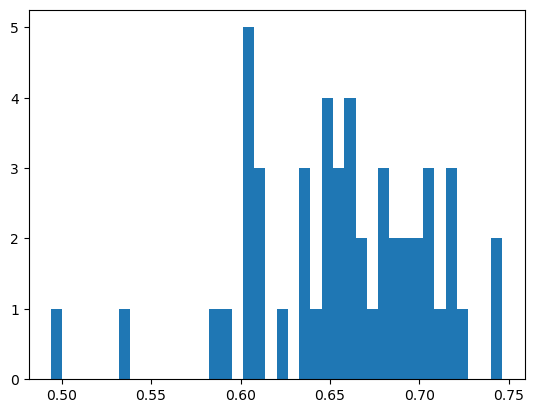

In [120]:
plt.hist(values, bins=40)

We can also **run the MCs in parallel** which speeds up the computation time - see the following and compare the calculation times!

In [121]:
# We can also create parallel Monte Carlo that will run simultations on multiple workers simultaneoulsy
bc.ParallelMonteCarlo?

Init signature:
bc.ParallelMonteCarlo(
    demand,
    method,
    iterations=1000,
    chunk_size=None,
    cpus=None,
    log_config=None,
)
Docstring:      Split a Monte Carlo calculation into parallel jobs
File:           c:\users\tl268686\appdata\local\anaconda3\envs\tuto\lib\site-packages\bw2calc\monte_carlo.py
Type:           type
Subclasses:     

In [122]:
pmc = bc.ParallelMonteCarlo(mc.demand, mc.method, iterations=n_runs)

In [123]:
%%time
values = pmc.calculate()

CPU times: total: 125 ms
Wall time: 1min 40s


(array([1., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 2., 2., 3., 5.,
        2., 3., 2., 3., 1., 0., 0., 3., 1., 2., 2., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 1.]),
 array([0.48957627, 0.49833277, 0.50708927, 0.51584578, 0.52460228,
        0.53335879, 0.54211529, 0.5508718 , 0.5596283 , 0.5683848 ,
        0.57714131, 0.58589781, 0.59465432, 0.60341082, 0.61216732,
        0.62092383, 0.62968033, 0.63843684, 0.64719334, 0.65594985,
        0.66470635, 0.67346285, 0.68221936, 0.69097586, 0.69973237,
        0.70848887, 0.71724538, 0.72600188, 0.73475838, 0.74351489,
        0.75227139, 0.7610279 , 0.7697844 , 0.7785409 , 0.78729741,
        0.79605391, 0.80481042, 0.81356692, 0.82232343, 0.83107993,
        0.83983643]),
 <BarContainer object of 40 artists>)

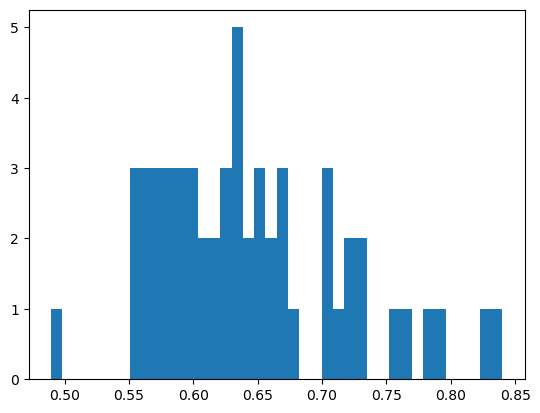

In [124]:
plt.hist(values, bins=40)

**One functional unit, multiple impact categories**

In [183]:
# define the function for MC simulation
def multiImpactMonteCarloLCA(functional_unit, list_methods, iterations):
    # Step 1
    MC_lca = bc.MonteCarloLCA(functional_unit)
    MC_lca.lci()
    # Step 2
    C_matrices = {}
    # Step 3
    for method in list_methods:
        MC_lca.switch_method(method)
        C_matrices[method] = MC_lca.characterization_matrix
    # Step 4
    results = np.empty((len(list_methods), iterations))
    # Step 5
    for iteration in range(iterations):
        next(MC_lca)
        for method_index, method in enumerate(list_methods):
            results[method_index, iteration] = (C_matrices[method]*MC_lca.inventory).sum()
    return results

# define the LCIA methods, functional unit, and the number of iterations
list_methods=[m for m in bd.methods if 'EF v3' in str(m) and 'no LT' not in str(m) and 'EN15' not in str(m)]
fu = {act_cement:1}
iterations = 100

# let it run!
test_results = multiImpactMonteCarloLCA(fu, list_methods, iterations)
test_results

array([[5.52925207e-03, 5.39892709e-03, 5.30676216e-03, ...,
        5.33759278e-03, 5.45583740e-03, 5.64012425e-03],
       [4.67560356e-01, 4.72314519e-01, 4.63945987e-01, ...,
        4.67512520e-01, 4.89040014e-01, 4.77747817e-01],
       [1.51205008e-03, 3.86556717e-03, 3.88867963e-03, ...,
        2.41596367e-03, 5.56686735e-03, 2.16766481e-03],
       ...,
       [1.20814209e-08, 1.40081745e-08, 1.07567942e-08, ...,
        1.25319408e-08, 1.40166169e-08, 1.15211596e-08],
       [1.48907005e-03, 1.75169613e-03, 1.62806039e-03, ...,
        1.59961484e-03, 1.84575500e-03, 1.60839977e-03],
       [5.53717081e-01, 4.66736852e-01, 3.77845948e-01, ...,
        4.93102002e-01, 5.56530913e-01, 4.40228652e-01]])

(array([2., 3., 3., 2., 2., 5., 4., 7., 6., 5., 9., 5., 6., 7., 3., 6., 3.,
        3., 3., 4., 1., 3., 3., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([0.44079095, 0.44397546, 0.44715996, 0.45034447, 0.45352897,
        0.45671348, 0.45989798, 0.46308249, 0.46626699, 0.4694515 ,
        0.472636  , 0.47582051, 0.47900501, 0.48218952, 0.48537402,
        0.48855853, 0.49174303, 0.49492754, 0.49811204, 0.50129655,
        0.50448105, 0.50766556, 0.51085006, 0.51403457, 0.51721907,
        0.52040358, 0.52358808, 0.52677259, 0.52995709, 0.5331416 ,
        0.5363261 , 0.53951061, 0.54269511, 0.54587962, 0.54906412,
        0.55224863, 0.55543313, 0.55861764, 0.56180214, 0.56498665,
        0.56817115]),
 <BarContainer object of 40 artists>)

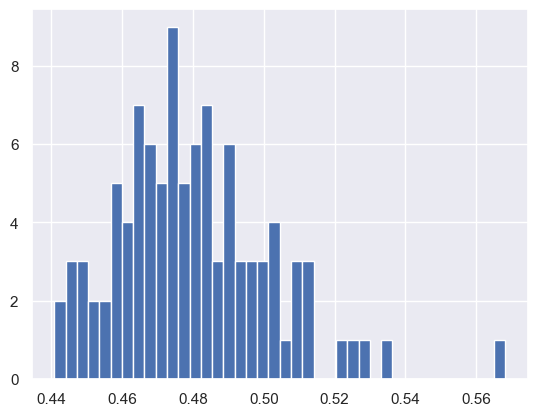

In [184]:
#we can get the plots for all 34 ILCD methods (--> type: len(ILCD)) by changing the index in the brackets
plt.hist(test_results[1], bins=40)

<a id='section4'></a>
# 4. Sensitivity analysis


## 4.1 One-at-a-time analysis (OAT)

OAT aims to evaluate the influence of the results by moving one parameter at a time to highlight **local sensitivity**.

```lca_algebraic```  provide several functions for computing **statistics** for **local variations** of parameters (one at a time).
 
> oat_matrix(model, impacts)
 
 Shows a **matrix of impacts x parameters** colored according to the variation of the impact in the bounds of the parameter.

 

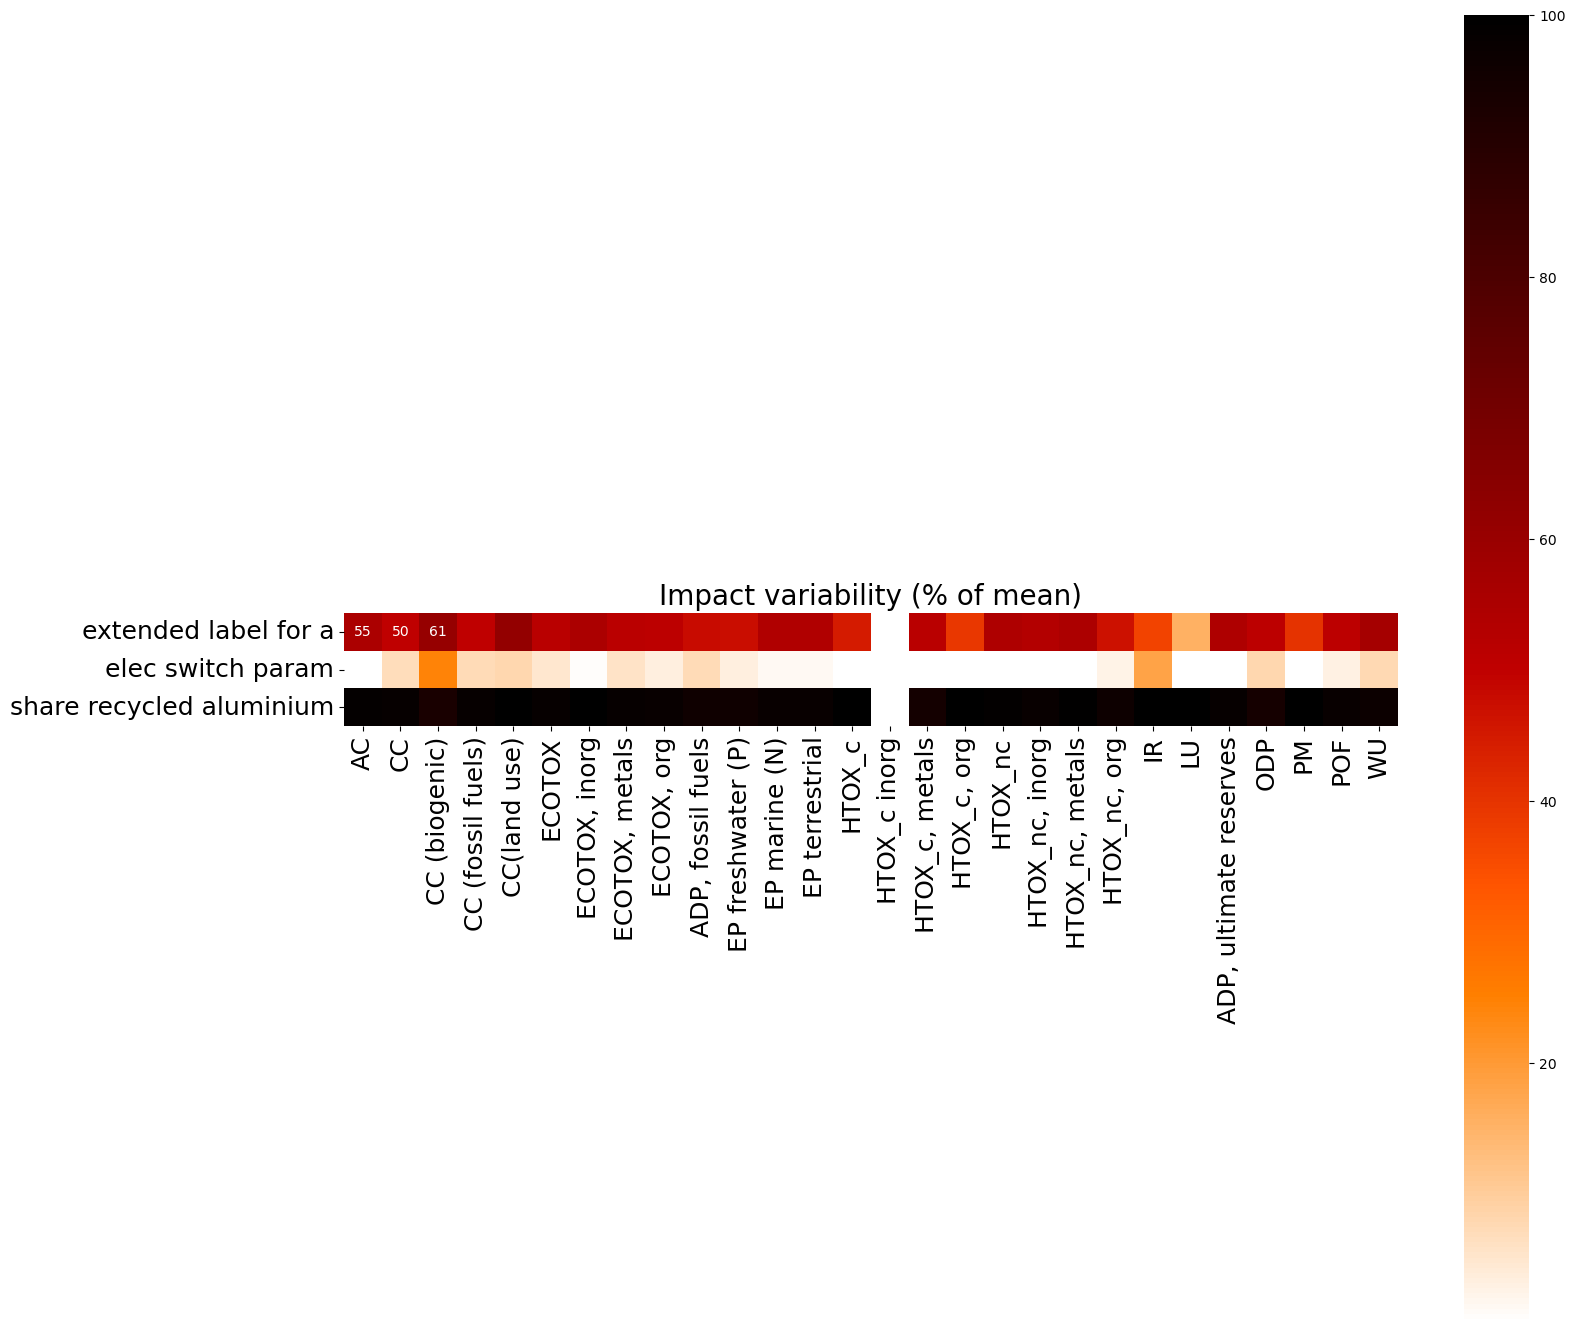

In [129]:
oat_matrix(model, list_methods)

>oat_dashboard_matrix

This functions draws a dashboard showing :
* A dropdown list, for choosing a parameter
* Several graphs of evolution of impacts for this parameter
* Full table of data
* A graph of "bars" representing the variation of each impact for this parameter (similar to the information given in oat_matrix) 

<div class="alert alert-block alert-danger">

this might **not work** on IDE (VSCode, Pycharm...) that would probably require some extra pluging for displaying the nice dashboard. 

But in Jupyter, it should work
</div>




In [130]:
oat_dashboard_interact(
    model, list_methods, 
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

interactive(children=(Dropdown(description='param', options=('a', 'share_recycled_aluminium', 'elec_switch_par…

## 4.2 Global Sensitivity analysis (GSA)

GSA leverage fast computation of monte-carlo approches. 

Similar to OAT matrix, we compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

for easier comparison, we translate those relative sobol indices into "deviation / mean" importance :

$$RelativeDeviation = \frac{\sqrt{sobol(param) \times totalVariance(impact))}}{mean(impact)}$$




Show sobol indices 

In [132]:
incer_stochastic_matrix(model, list_methods)

Generating samples ...
Transforming samples ...


c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Processing Sobol indices ...
Processing sobol for ('EF v3.0 no LT', 'acidification no LT', 'accumulated exceedance (AE) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change: biogenic no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change: fossil no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change: land use and land use change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater, inorganics no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater, metals no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Pr

interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…

another way to display these kind of results is to show **violin graphs**: the exact probabilitstic distribution for each impact, wih medians means and standard deviation

Generating samples ...
Transforming samples ...


c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
Param 'b' is marked as FIXED, but passed in parameters : ignored


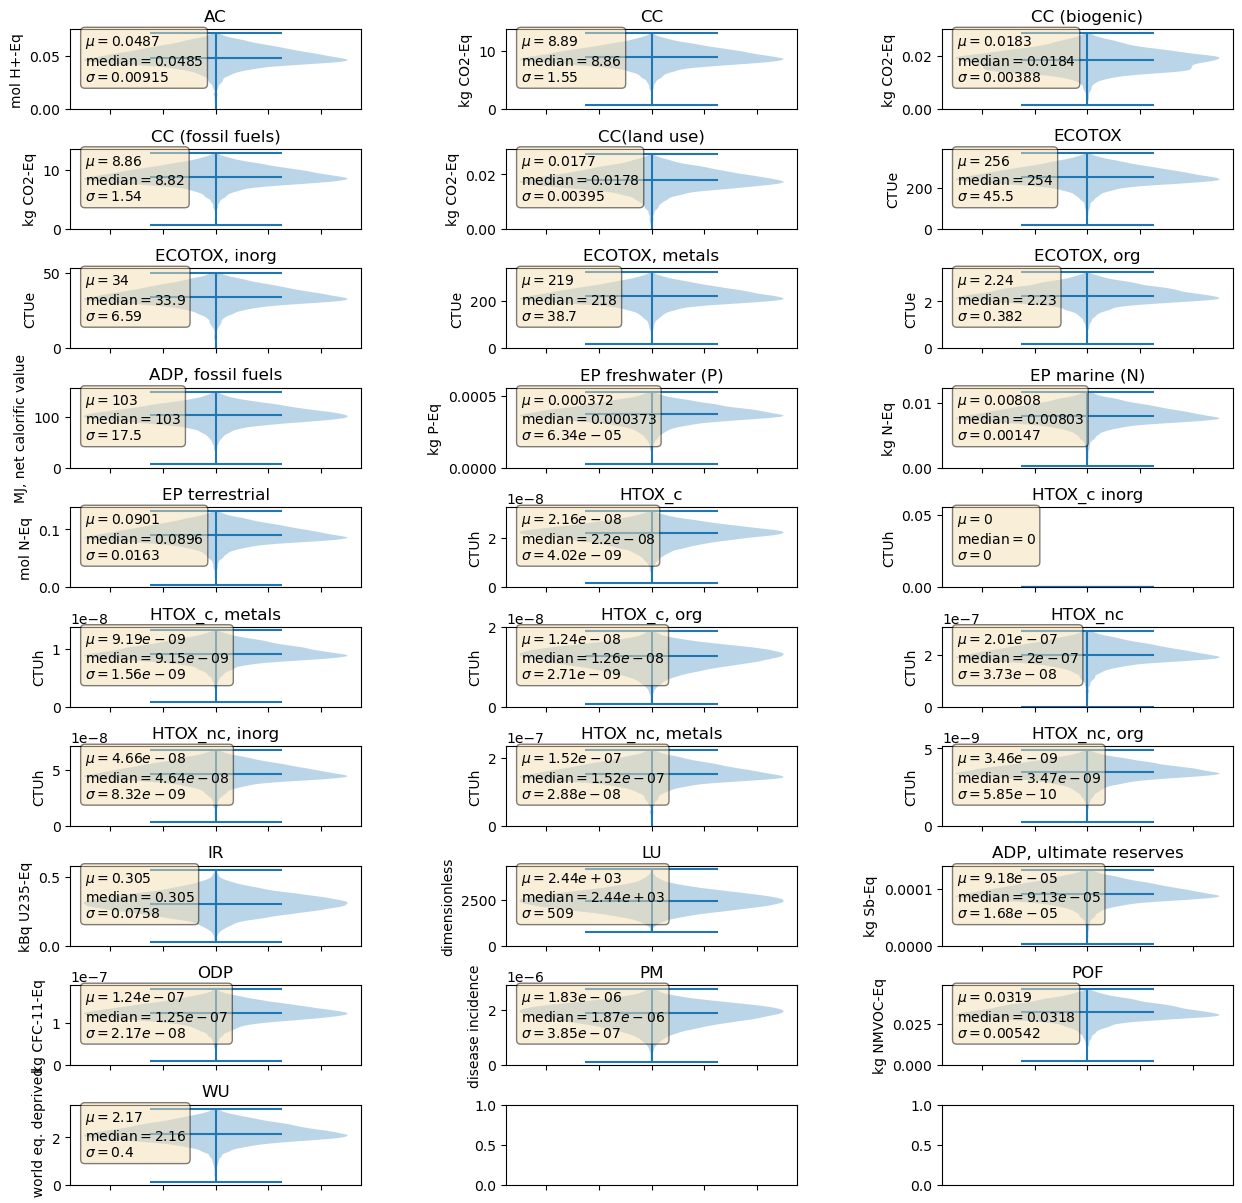

In [134]:
incer_stochastic_violin(
    model, list_methods,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes


Generating samples ...


c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Param 'b' is marked as FIXED, but passed in parameters : ignored


,AC [mol H+-Eq / kWh],CC [kg CO2-Eq / kWh],CC (biogenic) [kg CO2-Eq / kWh],CC (fossil fuels) [kg CO2-Eq / kWh],CC(land use) [kg CO2-Eq / kWh],ECOTOX [CTUe / kWh],"ECOTOX, inorg [CTUe / kWh]","ECOTOX, metals [CTUe / kWh]","ECOTOX, org [CTUe / kWh]","ADP, fossil fuels [MJ, net calorific value / kWh]",...,"HTOX_nc, inorg [CTUh / kWh]","HTOX_nc, metals [CTUh / kWh]","HTOX_nc, org [CTUh / kWh]",IR [kBq U235-Eq / kWh],LU [dimensionless / kWh],"ADP, ultimate reserves [kg Sb-Eq / kWh]",ODP [kg CFC-11-Eq / kWh],PM [disease incidence / kWh],POF [kg NMVOC-Eq / kWh],WU [m3 world eq. deprived / kWh]
median,0.048514,8.867911,0.018442,8.832945,0.017784,254.538038,33.936706,218.488089,2.234017,102.833657,...,0.0,0.0,0.0,0.305676,2442.814314,0.000091,0.0,0.000002,0.031752,2.163472
std,0.009176,1.556487,0.003869,1.550544,0.003949,45.66714,6.606232,38.873916,0.384081,17.607055,...,0.0,0.0,0.0,0.07587,509.213352,0.000017,0.0,0.0,0.00544,0.400191
p,"[0.03364236514746962, 0.06341205441684238]","[6.374165896596135, 11.392493032700575]","[0.0123499589124581, 0.024755288472291324]","[6.347772756341864, 11.345018312838238]","[0.011020622555994524, 0.023815331878638588]","[181.28072421738918, 328.57504564695387]","[23.04516546074438, 44.439645671071396]","[156.04483366661754, 281.56537386575263]","[1.620775424553425, 2.863187112602084]","[73.31504529173641, 130.5735116292139]",...,"[3.303931864157022e-08, 6.001543617477889e-08]","[1.0463201282934803e-07, 1.9831713894453998e-07]","[2.4324256127266716e-09, 4.356872695310211e-09]","[0.17803392892472011, 0.42864574140220413]","[1602.1778545383404, 3276.422069301414]","[6.413795084429086e-05, 0.00011890229859836871]","[8.763630702163447e-08, 1.5820241232316002e-07]","[1.1345127579675898e-06, 2.393821622791952e-06]","[0.02305560135622643, 0.04064068041372419]","[1.527862131486171, 2.822570113388612]"
mean,0.048708,8.89291,0.018332,8.856848,0.01773,255.477542,34.008381,219.225396,2.243765,102.736616,...,0.0,0.0,0.0,0.304717,2441.485871,0.000092,0.0,0.000002,0.031883,2.173145
var,0.188382,0.175026,0.211043,0.175067,0.222739,0.178752,0.194253,0.177324,0.171177,0.171381,...,0.178959,0.18935,0.169731,0.248986,0.208567,0.184173,0.174876,0.211383,0.17063,0.184153


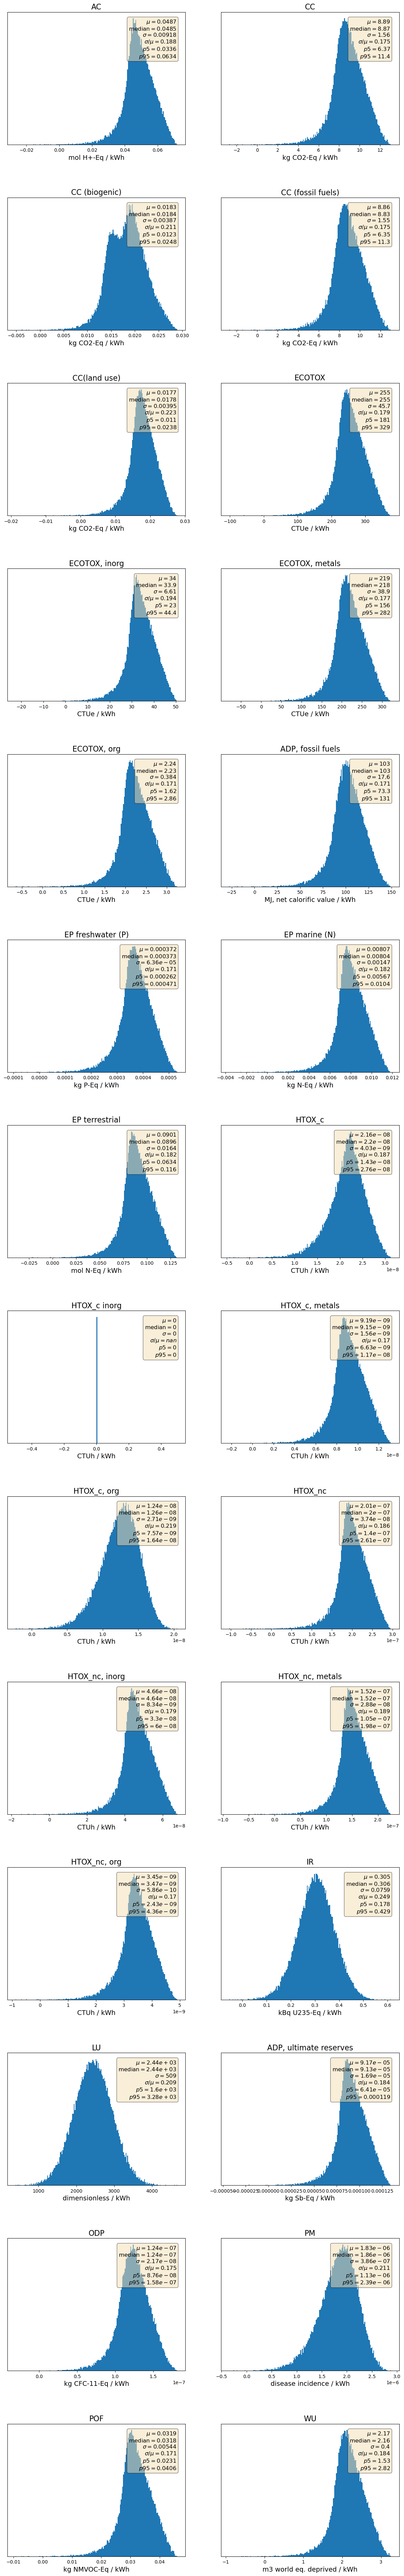

In [135]:
distrib(
    model, list_methods,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

A dashboard groups all this information in a single interface with tabs.

It also shows total variation of impacts. This last graph could be improved by showing stacked colored bars with the contribution of each parameter to this variation, according to Sobol indices. 

In [136]:
incer_stochastic_dashboard(model=model, methods=list_methods)

Generating samples ...
Transforming samples ...


c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
Param 'b' is marked as FIXED, but passed in parameters : ignored


Processing Sobol indices ...
Processing sobol for ('EF v3.0 no LT', 'acidification no LT', 'accumulated exceedance (AE) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change: biogenic no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change: fossil no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change: land use and land use change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater, inorganics no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater, metals no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Pr

## 4.3 Producing simplified models

One of te outcome of the statisticall analysis above would be to identify main input parameters and produce simplidied models, fixing the minor ones.

````lca_algebraic```` provide several functions for doing this.

First, let's look at the full expression defining our model

In [137]:
expr, _ = actToExpression(normalized_model)
expr

(0.4*a*aluminium_alloy_production_AlMg3 + 3*share_recycled_aluminium*(2.8*Heat_waste + 6.0*Occupation_industrial_area + 12*aluminium_scrap_new_Recycled_Content_cut_off + 1.272*elec_switch_param_eu*market_group_for_electricity_medium_voltage1 + 1.59*elec_switch_param_us*market_group_for_electricity_medium_voltage + market_for_aluminium_cast_alloy*(0.965 - 0.965*share_recycled_aluminium) + 0.00406*market_for_cast_iron + 0.00102*market_for_copper_cathode + 0.0305*market_for_magnesium + 0.00508*market_for_manganese + 0.00406*market_for_silicon_metallurgical_grade + 0.00203*market_for_zinc) + (0.7*Heat_waste + 1.5*Occupation_industrial_area)*(a + 3.5))/(a + 5)

We provide some method to automatically select a subset of parameters, based on the **sobol indices**, and then compute simplified models for it.

We also round numerical expression to 3 digits, and we remove terms in sums that are less than 1% of total.


In [143]:
simplified = sobol_simplify_model(
    normalized_model, # The model
    [list_methods[0],list_methods[1]], # Impacts to consider, could be done on the whole list (but longer)
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain

    num_digits=3)

Generating samples ...


c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Param 'b' is marked as FIXED, but passed in parameters : ignored


Processing sobol for ('EF v3.0 no LT', 'acidification no LT', 'accumulated exceedance (AE) no LT')
Processing sobol for ('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
> Method :  AC
S1:  0.9973691388425477
S2:  -0.00662575180298413
ST:  1.003004098692202
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9972569036957859


(0.0174*A - 3*ShareRecycledAluminium*(0.0359*ShareRecycledAluminium - 0.0423))/(A + 5)

> Method :  CC
S1:  0.9900978320302553
S2:  -0.005397055196033423
ST:  1.0105396421338406
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9277922083380483


(2.92*A - 3*ShareRecycledAluminium*(5.67*ShareRecycledAluminium - 7.26))/(A + 5)

Let's look at the expression for first impact again 
much simpler ! 


In [144]:
simplified[0].expr

(0.0174*a - 3*share_recycled_aluminium*(0.0359*share_recycled_aluminium - 0.0423))/(a + 5)

You can also compare the simplified expression with the complete one with

Generating samples ...
Transforming samples ...


c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\lca_algebraic\stats.py:1125: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.text(0.9, r2_height, "R² : %0.3g" % r_value, transform=ax.transAxes, fontsize=14,


Generating samples ...
Transforming samples ...


c:\Users\TL268686\AppData\Local\anaconda3\envs\tuto\Lib\site-packages\lca_algebraic\stats.py:1125: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.text(0.9, r2_height, "R² : %0.3g" % r_value, transform=ax.transAxes, fontsize=14,


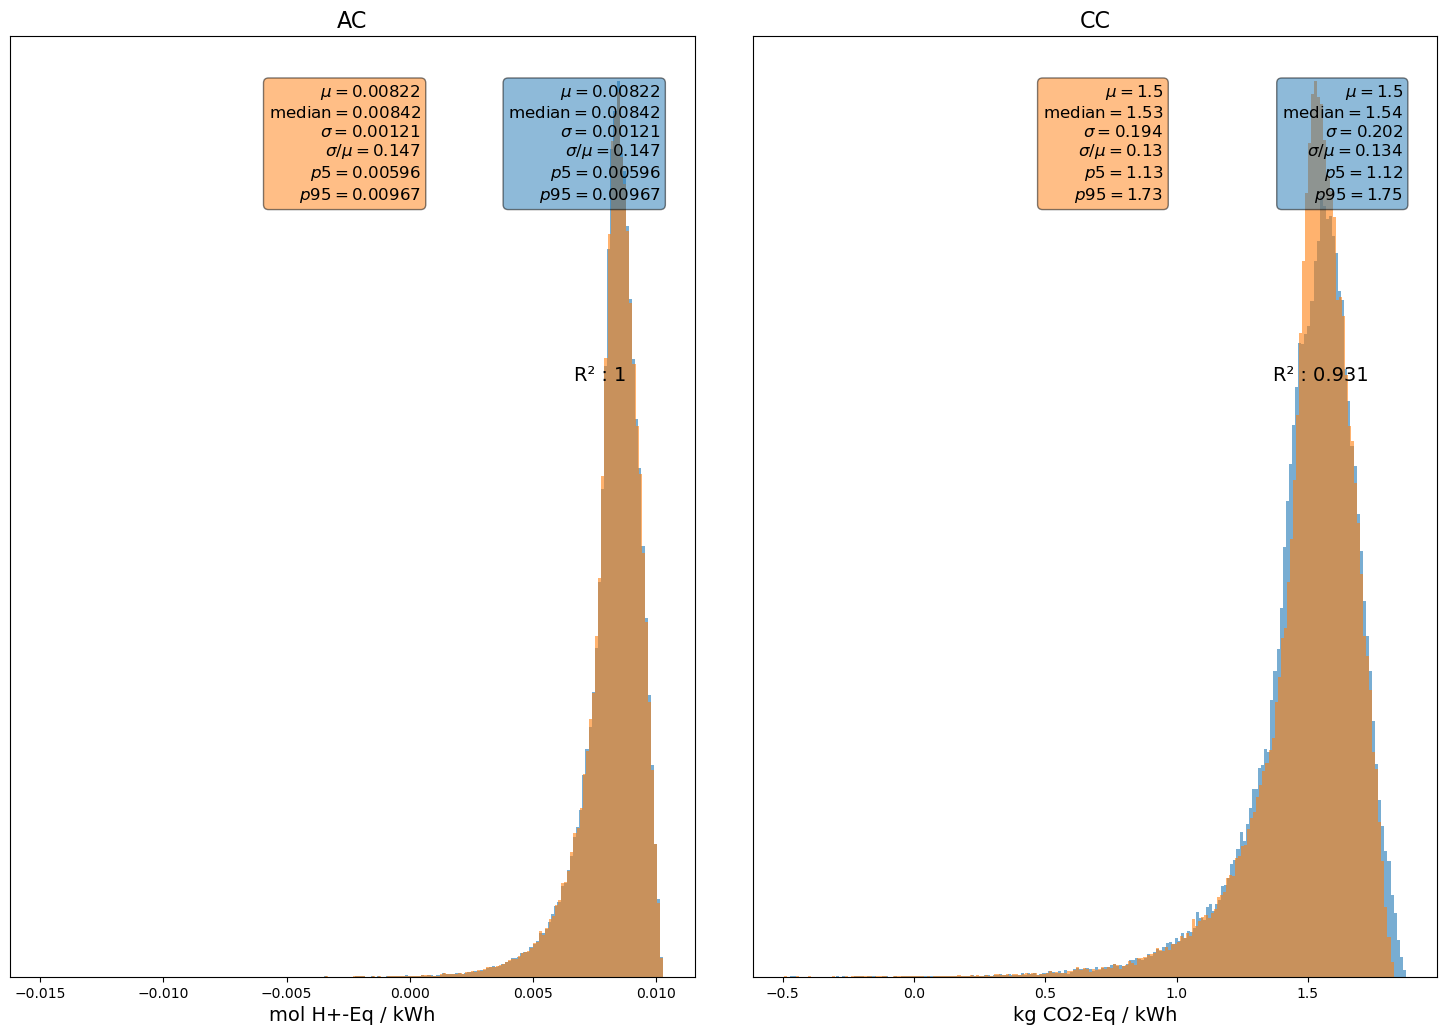

In [145]:
compare_simplified(normalized_model, [list_methods[0],list_methods[1]], simplified)

<a id='section5'></a>
# 5. Prospective LCA with premise


This section is inspired by the example notebook of the official [Gihub tutorial](https://github.com/polca/premise/blob/master/examples/examples.ipynb). 

````premise```` is a Python tool for **prospective life cycle assessment**. It allows users to project the ecoinvent 3 database into the future, using scenarios from **Integrated Assessment Models** (IAMs). It does so **by modifying the ecoinvent database** to reflect projected energy policy trajectories, include emerging technologies, modify market shares as well as technologies' efficiency. This allows for the **creation of life cycle inventory databases under future policy scenarios for any year** between 2005 and 2100.

<img src="images/premise.png"  width="100" style="display: block; margin: 0 auto">

The tool is described in scientific publication [Sacchi et al, 2022](https://doi.org/10.1016/j.rser.2022.112311) and the official [documentation](https://premise.readthedocs.io/en/latest/extract.html#current-iam-scenarios)  is provided [here](https://premise.readthedocs.io/en/latest/) and the [Github repository](https://github.com/polca/premise/tree/master?tab=readme-ov-file)



<img src="images/main_workflow.webp"  width="700" style="display: block; margin: 0 auto">

This library extract useful information from IAM model output files (such as those of REMIND or IMAGE) and aligns inventories in the ecoinvent database accordingly. They are proposed in combination with different climate mitigation targets, called Representative Concentration Pathways (RCP). For now SSP1 SSP2 and SSP5 with several RCP are already installed with premise. The full list of avalaible scenarios in premise are described in the documentation and an interactive dashboard is avalaible [here](https://premisedash-6f5a0259c487.herokuapp.com/). Additionally, [this blog](https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/) is a good reading material to understand SSPs and RCPs.


premise enables users to seamlessly integrate custom scenarios, in addition to (or as an alternative to) existing IAM scenarios. This feature is particularly useful when users wish to incorporate projections for a sector, product, or technology that may not be adequately addressed by standard IAM scenarios. A dedicated [Github repository](https://github.com/premise-community-scenarios) exists to share all the user-defined scenarios from the community and to give examples on the way to process.

In [4]:
from premise import *

In [5]:
bd.databases

Databases dictionary with 0 objects

## 5.1 Load the additionnal inventories of the scenarios

In [20]:
from premise import *

In [21]:
clear_cache()
ndb = NewDatabase(
    scenarios=[
        {"model":"remind", "pathway":"SSP2-Base", "year":2030},
        {"model":"remind", "pathway":"SSP2-Base", "year":2050},
    ],
    source_db="ecoinvent 3.9.1_cutoff", # <-- name of the database in the BW2 project. Must be a string.
    source_version="3.9.1", # <-- version of ecoinvent. Can be "3.5", "3.6", "3.7" or "3.8" or 3.9/3.9.1. Must be a string.
    
    key='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', # <-- decryption key
    # this key must be requested from the library maintainers (romain sacchi) if you want ot use default scenarios included in `premise`
    
    use_multiprocessing=True, # True by default, set to False if multiprocessing is causing troubles
    keep_uncertainty_data=False, # False by default, set to True if you want to keep ecoinvent's uncertainty data
    use_absolute_efficiency=False, # False by default, set to True if you want to use the IAM's absolute efficiency for power plants
    quiet=True
)


Cache folder cleared!
- Extracting source database
Cannot find cached database. Will create one now for next time...
Getting activity data


100%|██████████| 21255/21255 [00:00<00:00, 133692.94it/s]


Adding exchange data to activities


100%|██████████| 674610/674610 [00:49<00:00, 13668.55it/s]


Filling out exchange data


100%|██████████| 21255/21255 [00:02<00:00, 7748.79it/s] 


Set missing location of datasets to global scope.
Set missing location of production exchanges to scope of dataset.
Correct missing location of technosphere exchanges.
Correct missing flow categories for biosphere exchanges
Remove empty exchanges.
Remove uncertainty data.
- Extracting inventories
Cannot find cached inventories. Will create them now for next time...
Importing default inventories...

Extracted 1 worksheets in 0.26 seconds
Migrating to 3.8 first
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Remove uncertainty data.
Extracted 1 worksheets in 0.04 seconds
Migrating to 3.8 first
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Remove unce

Note that a cache of the database will be created the first time and store in the library folder. Any subsequent creation of databases using the same ecoinvent version will no longer require this extraction step.


>It is recommended to restart your notebook once the data has been cached for the first time, so that the remaining steps can be performed using the cached data (much faster).

If you do not want to integrate the IAM projections in the database, but only wish to have the additional inventories, you can stop here and export the database back to Brightway or other destinations, by using the `write_db_to` methods, like ```ndb.write_db_to_brightway()```

### Integrate the IAM models

The user can produce his/her own scenario by following the steps below:

- Clone an existing scenario repository from the public repository.
- Modify the scenario file (scenario_data/scenario_data.csv).
- Add any inventories needed, under inventories/lci-xxx.csv.
- Modify the configuration file (configuration_file/config.yaml), to instruct premise what to do.
- Ensure that the file names and paths above are consistent with what is indicated in datapackage.json.
- Once definitive, you can contact the admin of the public repository to add your scenario to the repository.

all instructions and examples are provided in a dedicated section in the [documentation](https://premise.readthedocs.io/en/latest/user_scenarios.html) and in a dedicated [Github repository](https://github.com/premise-community-scenarios)

## 5.2 Integrate IAM models

However, if you wish first to proceed with the IAM integration, you need to use the `update_` methods. With version 1.5.0, the following transformation are available:

* `update("biomass")`: create regional biomass markets, adjusting the share of residual vs. purpose-grown boimass for use in heat and power generation
* `update("electricity")`: create regional electricity markets and adjust efficiency of power plants, including that of photovoltaic panels
* `update("cement")`: creates regional markets for clinker production and adjust clinker production efficiency
* `update("steel")`: creates regional markets for steel and adjust steel production efficiency and the supply of secondary steel
* `update("dac")`: creates region- and scenario-specific inventories for Direct Air Capture (DAC) and Carbon Storage (DACCS) systems.
* `update("fuels")`: creates regional markets for liquid and gaseous fuels
* `update("heat")`: regionalize some heat and steam generation datasets (working on diesel, biomass and natural gas)
* `update("emissions")`: adjust emission of pollutants (PM, NOx, VOCs) for various activities, based on GAINS model projections.
* `update("two_wheelers")`: imports two-wheelers (bicycles, motorbikes, etc.)
* `update_cars()`: produces fleet average cars and relinks to activities consuming pasenger car transport
* `update("trucks")`: produces fleet average trucks and relinks to activities consuming lorry transport
* `update("buses")`: imports buses (urban and coach buses, single-deckers and double-deckers)

Alternatively, `update()` performs all the above-mentioned transformations (except `update("two_wheelers")`, `update("cars")` and `update("buses")`).

In [22]:
ndb.update()

`update()` will skip the following sectors: 'buses', 'cars', 'two_wheelers'.
If you want to update these sectors, please run them separately afterwards.


Updating: biomass:   0%|                       | 0/10 [00:16<?, ?it/s]


TypeError: argument of type 'NoneType' is not iterable

export it in BW:

In [ ]:
ndb.write_db_to_brightway()

We can check that this works: this should add new updated database:

In [ ]:
bd.databases

Databases dictionary with 4 object(s):
	Foreground DB
	biosphere3
	ecoinvent 3.9.1_cutoff
	water_bottle

Or export it as a sparse matrix representation with ```ndb.write_db_to_matrices()``` 

This will export four files:

* "A_matrix.csv": matrix coordinates and values of shape (index of activity; index of product; value) for the technosphere
* "A_matrix_index.csv": labels for indices for A matrix of shape (name of activity, reference product, unit, location, index)
* "B_matrix.csv": matrix coordinates and values of shape (index of activity; index of biosphere flow; value) for the biosphere
* "B_matrix_index.csv": labels for indices for B matrix of shape (name of biosphere flow, main compartment, sub-compartmnet, unit, index)

As a convenience, you can specifiy a directory where to store the exported matrices.
If the directory does not exist, it will be created.
If you leave it unspecified, they will be stored in **data/matrices** in the root folder of the library.

It is also possible to export it as a datapackage, superstructure database or SimaPro CSV file or OpenLCA (check the official documentation and example notebook if interested in code details)

## 5.3 Prospective LCA

Thus, premise enables the assessment of the impacts under several prospective decarbonization pathways.

Let's have a look on the evolution of the impact of the electricity production in France under SSP2-Baseline scenario in 2020, 2030 and 2050. 

First, we have to get the activity in each database.

In [ ]:
elecFR_2020 = findActivities('market for electricity, low voltage', location="FR", db_name=db_background)

elecFR_SSP2_2030 = findActivities('market for electricity, low voltage', location="FR", db_name=)

elecFR_SSP2_2050 = findActivities('market for electricity, low voltage', location="FR", db_name=db_background)
